In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy
from corner import corner

# Add the path to the symbolic_pofk module
sys.path.append(os.path.join(sys.path[0], 'hybridStats'))
from torch_codes.models import FCN,SimpleCNN

In [13]:
train_data_dir = '/home/suice/workspace/play_ground/dataset/train_data/final_data'
out_data_dir = '/home/suice/workspace/play_ground/experiment_results/ex_ce_test'

### Load data

In [3]:
total_img = np.load(f'{train_data_dir}/img_train.npy') #raw imgs
total_ps = np.load(f'{train_data_dir}/ps_train.npy') # power spectrum as base summaries

#normalize ps 
# total_ps_mean = total_ps.mean(axis=0)
# total_ps_std = total_ps.std(axis=0)

params = np.load(f'{train_data_dir}/params_train.npy')
total_img_test  = np.load(f'{train_data_dir}/img_test.npy')

In [4]:
X = torch.tensor(total_img/50).float()
X = X.unsqueeze(1)
X_test = torch.tensor(total_img_test/50).float()
X_test = X_test.unsqueeze(1)

S = torch.tensor(total_ps).float()

thetas = torch.tensor(params).float()

In [5]:
#train eval split
from sklearn.model_selection import train_test_split
X_train, X_eval, S_train, S_eval,  thetas_train, thetas_eval = train_test_split(X, S,  thetas, test_size=0.2, random_state=42)

## Train Compressor

In [11]:
class total_model(nn.Module):
    def __init__(self,compressor,classifier):
        super(total_model, self).__init__()

        self.compressor = compressor
        self.classifier = classifier

    def forward(self, img, sum,theta):

        extra_sum = self.compressor(img)
        total_input = torch.cat([extra_sum,sum,theta],dim=1)
        out = self.classifier(total_input)

        return out
    

def augument(imgs):
    '''
    Augument the images by rotating them to improve the robustness of the model
    '''

    rot_angle = np.random.choice([0, 1, 2, 3])
    # rotate
    imgs = torch.rot90(imgs, k=rot_angle, dims=[2, 3])

    return imgs

In [8]:
# training hyperparameters
batch_size = 256
epochs = 500
lr = 1e-4

# define the dim of the learned summaries
extra_dim = 2

In [9]:
compressor = SimpleCNN(extra_dim)
classifier = FCN(extra_dim+S.shape[1]+thetas.shape[1], [128,64,64], 1)

model = total_model(compressor,classifier)

device = 'cuda'
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [12]:
train_losses = []
val_losses = []
best_val_loss = np.inf
best_compressor = None

model.to(device=device)
X, S, thetas = X.to(device), S.to(device), thetas.to(device)
X_eval, S_eval, thetas_eval = X_eval.to(device), S_eval.to(device), thetas_eval.to(device)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    permutation = torch.randperm(X.size(0))
    for batch in range(0, X.size(0), batch_size):
        indices = permutation[batch:batch + batch_size]
        batch_x, batch_thetas, batch_s = X[indices], thetas[indices], S[indices]

        #augument
        batch_x = augument(batch_x)

        #shuffle thetas to produce samples for negative class P(s)P(theta)
        batch_thetas_shuffle = batch_thetas[torch.randperm(batch_thetas.size(0))]

        #labels for the two classes: positive p(s,theta), negative p(s)p(theta)
        labels = torch.ones(batch_x.size(0)*2)
        labels[batch_x.size(0):] = 0

        batch_x = torch.cat([batch_x,batch_x],dim=0)
        batch_thetas = torch.cat([batch_thetas,batch_thetas_shuffle],dim=0)
        batch_s = torch.cat([batch_s,batch_s],dim=0)

        batch_x, batch_thetas, batch_s, labels = batch_x.to(device), batch_thetas.to(device), batch_s.to(device), labels.to(device)

        optimizer.zero_grad()

        preds = model(batch_x, batch_s, batch_thetas)
        loss = loss_func(preds.squeeze(), labels)

        

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        correct += (torch.sigmoid(preds.squeeze())>0.5).eq(labels.byte()).sum().item()
    
    epoch_acc= correct / X.size(0)/2
    train_loss =  train_loss*batch_size / X.size(0)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    correct = 0
    permutation = torch.randperm(X_eval.size(0))

    with torch.no_grad():
        
        for batch in range(0, X_eval.size(0), batch_size):
            indices = permutation[batch:batch + batch_size]
            batch_x, batch_thetas, batch_s = X_eval[indices], thetas_eval[indices], S_eval[indices]
            batch_x = augument(batch_x)
            
            batch_thetas_shuffle = batch_thetas[torch.randperm(batch_thetas.size(0))]

            labels = torch.ones(batch_x.size(0)*2)
            labels[batch_x.size(0):] = 0

            batch_x = torch.cat([batch_x,batch_x],dim=0)
            batch_thetas = torch.cat([batch_thetas,batch_thetas_shuffle],dim=0)
            batch_s = torch.cat([batch_s,batch_s],dim=0)

            batch_x, batch_thetas, batch_s, labels = batch_x.to(device), batch_thetas.to(device), batch_s.to(device), labels.to(device)

            preds = model(batch_x, batch_s, batch_thetas)
            loss = loss_func(preds.squeeze(), labels)

            val_loss += loss.item()
            correct += (torch.sigmoid(preds.squeeze())>0.5).eq(labels.byte()).sum().item()
        
    epoch_acc_eval = correct / X_eval.size(0)/2
    val_loss =  val_loss*batch_size / X_eval.size(0)
    val_losses.append(val_loss)

    # save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_compressor = deepcopy(model.compressor)

    if epoch % 10 == 0:
        print(
            f'Epoch {epoch}: train_loss: {train_loss} val_loss: {val_loss} train_acc: {epoch_acc} val_acc: {epoch_acc_eval}'
        )

Epoch 0: train_loss: 0.7113975178458544 val_loss: 0.7093977737426758 train_acc: 0.5023004600920185 val_acc: 0.49925
Epoch 10: train_loss: 0.6110049890837542 val_loss: 0.5975127258300781 train_acc: 0.7683036607321464 val_acc: 0.7855
Epoch 20: train_loss: 0.423148695290816 val_loss: 0.41650305938720705 train_acc: 0.8422684536907381 val_acc: 0.84075
Epoch 30: train_loss: 0.35428285379365915 val_loss: 0.34671711349487305 train_acc: 0.8679235847169434 val_acc: 0.873
Epoch 40: train_loss: 0.3177951443407578 val_loss: 0.32708115768432616 train_acc: 0.8784756951390278 val_acc: 0.87225
Epoch 50: train_loss: 0.3051072952627635 val_loss: 0.31606274032592774 train_acc: 0.8826765353070614 val_acc: 0.879
Epoch 60: train_loss: 0.2909402101367539 val_loss: 0.2872574157714844 train_acc: 0.8873274654930986 val_acc: 0.88375
Epoch 70: train_loss: 0.27812739633803224 val_loss: 0.27277255249023435 train_acc: 0.8957291458291659 val_acc: 0.899
Epoch 80: train_loss: 0.2727644684362898 val_loss: 0.3030353012084

In [14]:
torch.save(best_compressor.state_dict(), f'{out_data_dir}/compressor_ce_bound_2extra.pth')

In [15]:
best_compressor.eval()

# X = X_train_all.to(device)
#compress all X using batchsize 64
extra_S = []
for batch in range(0, X.size(0), batch_size):
    batch_x = X[batch:batch + batch_size].to(device)
    extra_S.append(best_compressor(batch_x).detach().cpu().numpy())
extra_S = np.concatenate(extra_S,axis=0)

extra_S_test = []
X_test = X_test.to(device)
for batch in range(0, X_test.size(0), batch_size):
    batch_x = X_test[batch:batch + batch_size].to(device)
    extra_S_test.append(best_compressor(batch_x).detach().cpu().numpy())
extra_S_test = np.concatenate(extra_S_test,axis=0)

In [16]:
extra_S.shape, extra_S_test.shape

((9998, 2), (2048, 2))

In [17]:
np.save(f'{out_data_dir}/ce_extra_2_train.npy',extra_S)
np.save(f'{out_data_dir}/ce_extra_2_test.npy',extra_S_test)

## Test new summaries

### regression

In [18]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [19]:
def train_lgbm(X_train, ytrain):
    
    xtrain, xeval, ytrain, yeval = train_test_split(X_train, ytrain, test_size=0.2, random_state=42)

    dtr = lgb.LGBMRegressor(objective='regression',
                            num_leaves=31,
                            learning_rate=1e-1,
                            min_data_in_leaf=200,
                            n_estimators=200,
                            importance_type='gain',
                            random_state=1)
    
    dtr.fit(xtrain,
            ytrain,
            eval_set=[(xeval, yeval)],
            eval_metric=['l2'],
            callbacks=[early_stopping(5)])

    return dtr

def prediction_plots(ytrue, ypred, title):
    fig, ax = plt.subplots()
    r2 = r2_score(ytrue, ypred)
    rmse = np.sqrt(np.mean((ytrue - ypred)**2))

    ax.scatter(ytrue, ypred, s=1)
    ax.plot([ytrue.min(), ytrue.max()], [ytrue.min(), ytrue.max()], 'k--', lw=1)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(title)

    ax.text(0.05, 0.85, f'R2: {r2:.2f}\nRMSE: {rmse:.2f}', transform=ax.transAxes)
    plt.show()

In [20]:
ps_train = np.load(f'{train_data_dir}/ps_train.npy')
extra_S_train = np.load(f'{out_data_dir}/ce_extra_2_train.npy')
y_train = np.load(f'{train_data_dir}/params_train.npy')
total_S_train = np.concatenate([ps_train,extra_S_train],axis=1)

ps_test = np.load(f'{train_data_dir}/ps_test.npy')
extra_S_test = np.load(f'{out_data_dir}/ce_extra_2_test.npy')
y_test = np.load(f'{train_data_dir}/params_test.npy')
total_S_test = np.concatenate([ps_test,extra_S_test],axis=1)


In [23]:
param_idx = 0
dtr_S = train_lgbm(ps_train, y_train[:, param_idx])
dtr_S_with_extra = train_lgbm(total_S_train, y_train[:, param_idx])

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 0.0869348
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0743716


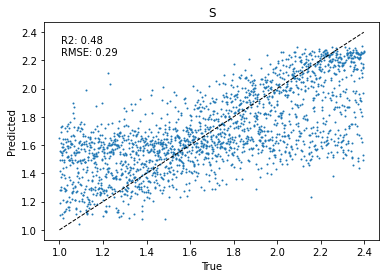

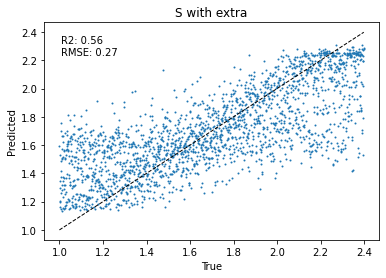

In [24]:
y_pred_S = dtr_S.predict(ps_test)
y_pred_S_with_extra = dtr_S_with_extra.predict(total_S_test)

prediction_plots(y_test[:, param_idx], y_pred_S, 'S')
prediction_plots(y_test[:, param_idx], y_pred_S_with_extra, 'S with extra')

### sbi

In [29]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.colors as mcolors

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [27]:
ps_train = np.load(f'{train_data_dir}/ps_train.npy')
y_train = np.load(f'{train_data_dir}/params_train.npy')

ps_test = np.load(f'{train_data_dir}/ps_test.npy')
y_test = np.load(f'{train_data_dir}/params_test.npy')

extra_S_train = np.load(os.path.join(out_data_dir,'ce_extra_2_train.npy'))
total_S_train = np.concatenate([ps_train,extra_S_train],axis=1)

extra_S_test = np.load(os.path.join(out_data_dir,'ce_extra_2_test.npy'))
total_S_test = np.concatenate([ps_test,extra_S_test],axis=1)

#### sbi ps

In [24]:
loader = NumpyLoader(x=ps_train, theta=y_train)

In [25]:
# define a prior
prior = ili.utils.Uniform(low=[1, 4], high=[2.4, 6], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [26]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


 Training neural network. Epochs trained: 96

INFO:root:It took 17.575665950775146 seconds to train models.


 Neural network successfully converged after 97 epochs.

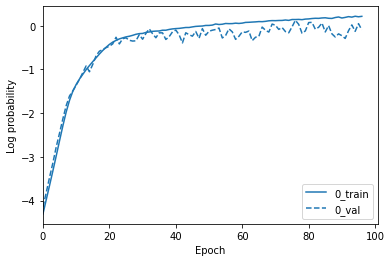

In [27]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

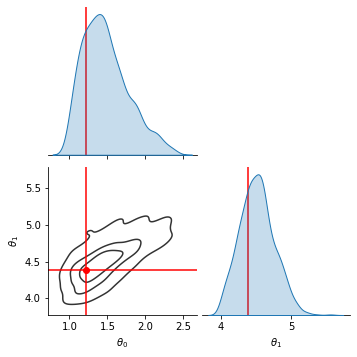

In [28]:
ind = 0
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(2)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = ps_test[ind], theta_fid=y_test[ind]
)

100%|██████████| 2048/2048 [00:18<00:00, 113.60it/s]


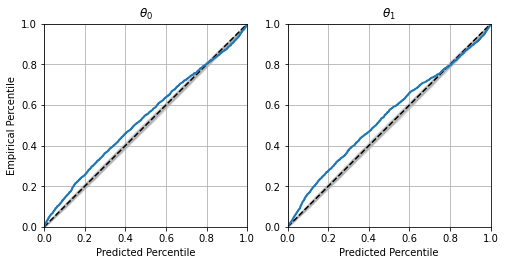

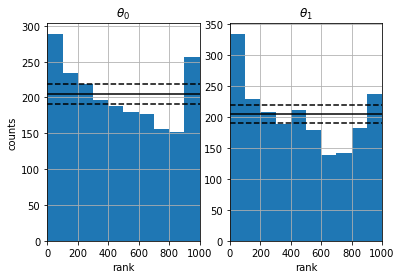

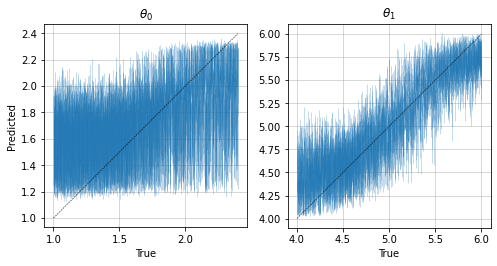

In [29]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(2)],
    plot_list = ["coverage", "histogram", "predictions"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=ps_test, theta=y_test
)

In [19]:
import pickle
import json
import os
out_dir = out_data_dir

In [20]:
str_p = 'ps_posterior_ensemble.pkl'
str_s = 'ps_summaries.json'
with open(os.path.join(out_dir,str_p), "wb") as handle:
    pickle.dump(posterior_ensemble, handle)
with open(os.path.join(out_dir,str_s), "w") as handle:
    json.dump(summaries, handle)

#### sbi ps+extra

In [30]:
loader = NumpyLoader(x=total_S_train, theta=y_train)

In [31]:
# define a prior
prior = ili.utils.Uniform(low=[1, 4], high=[2.4, 6], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [32]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


 Neural network successfully converged after 169 epochs.

INFO:root:It took 603.0388820171356 seconds to train models.


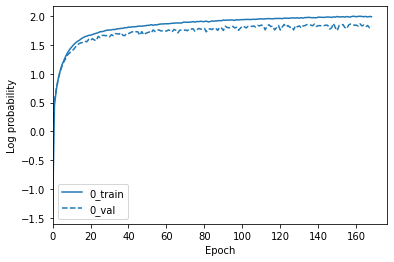

In [33]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

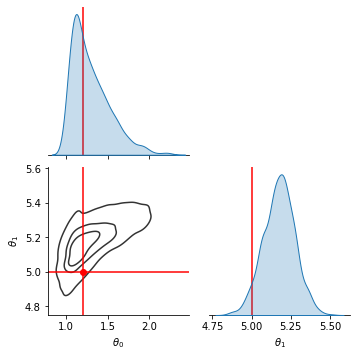

In [34]:
ind = np.random.randint(0, len(ps_test))
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(2)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = total_S_test[ind], theta_fid=y_test[ind]
)

100%|██████████| 2048/2048 [00:16<00:00, 125.01it/s]


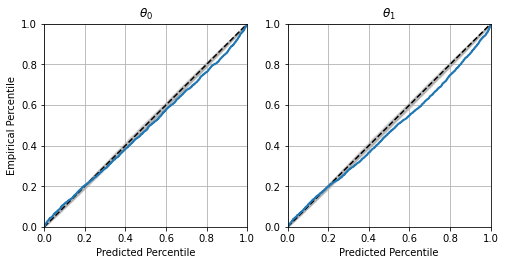

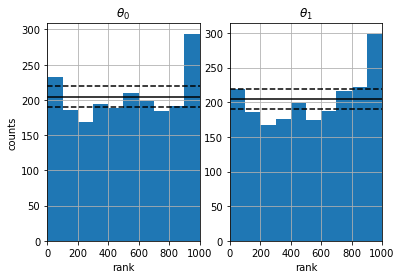

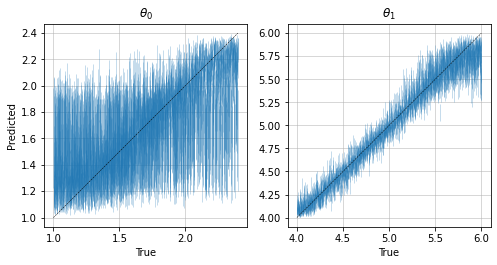

In [35]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(2)],
    plot_list = ["coverage", "histogram", "predictions"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=total_S_test, theta=y_test
)

In [37]:
import pickle
import json

In [38]:
str_p = 'ps_withce_extra_posterior_ensemble.pkl'
str_s = 'ps_withce_extra_summaries.json'
with open(os.path.join(out_data_dir,str_p), "wb") as handle:
    pickle.dump(posterior_ensemble, handle)
with open(os.path.join(out_data_dir,str_s), "w") as handle:
    json.dump(summaries, handle)

## Make Comparison

In [40]:
ps_test = np.load(f'{train_data_dir}/ps_test.npy')
y_test = np.load(f'{train_data_dir}/params_test.npy')

extra_S_CE_test = np.load(os.path.join(out_data_dir,'ce_extra_2_test.npy'))
total_S_CE_test = np.concatenate([ps_test,extra_S_CE_test],axis=1)

# to tensor 
ps_test = torch.tensor(ps_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
extra_S_CE_test = torch.tensor(extra_S_CE_test, dtype=torch.float32).to(device)
total_S_CE_test = torch.tensor(total_S_CE_test, dtype=torch.float32).to(device)

In [51]:
ps_posmodel_path = os.path.join(out_data_dir,'ps_posterior_ensemble.pkl')

with open(ps_posmodel_path, "rb") as handle:
    posterior_ensemble_ps = pickle.load(handle)


extra_posmodel_path = os.path.join(out_data_dir,'ps_withce_extra_posterior_ensemble.pkl')

with open(extra_posmodel_path, "rb") as handle:
    posterior_ensemble_ce = pickle.load(handle)

In [72]:
test_idx = np.random.randint(len(ps_test))
print('Test idx:', test_idx)

epe_pos = posterior_ensemble_ce.sample((1000,),x= total_S_CE_test[test_idx]).detach().cpu().numpy()
ps_pos = posterior_ensemble_ps.sample((1000,),x= ps_test[test_idx]).detach().cpu().numpy()

Test idx: 1514


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

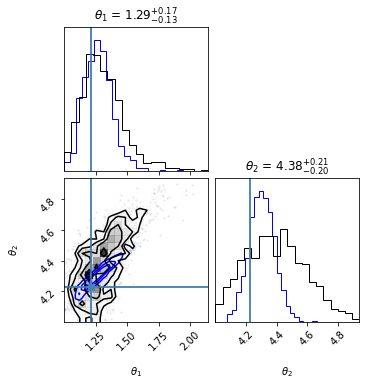

In [73]:
fig = corner(epe_pos, labels=[r"$\theta_1$", r"$\theta_2$"], truths=y_test[test_idx].cpu().numpy(), show_titles=True, title_kwargs={"fontsize": 12},color='blue');
corner(ps_pos, labels=[r"$\theta_1$", r"$\theta_2$"], truths=y_test[test_idx].cpu().numpy(), show_titles=True, title_kwargs={"fontsize": 12}, fig=fig,color='black');